<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Practice MLR using the Sacramento Real Estate Data

_Authors: Joseph Nelson (DC), Matt Brems (DC)_

---

We return to the Sacramento real estate data, but this time around we will be constructing multiple linear regression models. 

You will review the assumptions of multiple linear regression and practice building a model using the statsmodels package.

### 1. Load the data. 

In [38]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats as stats

%matplotlib inline

In [2]:
!head -4 datasets/sacramento_real_estate_transactions_Clean.csv

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839


In [3]:
sac = pd.read_csv('datasets/sacramento_real_estate_transactions_Clean.csv',
           index_col=0)

In [4]:
# no nulls
sac.isnull().sum().sum()

0

In [5]:
# see if we have any negative prices
sac[ sac['price'] < 0 ]

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude


In [8]:
len(sac.index)

984

In [9]:
# drop 0 sqft rows
sac.drop(index=sac[ sac['sq__ft'] < 1 ].index.tolist(), inplace=True)

# drop rows with sqft greater than 4 stdevs from the mean
sac.drop(index=sac[ sac['sq__ft'] > sac['sq__ft'].mean() + (4 * sac['sq__ft'].std()) ].index[0],
         inplace=True)

In [14]:
sac.reset_index(drop=True, inplace=True)

## Dummy Variables

---

It is important to be cautious with categorical variables, those that represent distict groups or categories, when building a regression. If put in a regression "as-is", categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.

### 2. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

Print out the header of the dummy-coded variable output.

In [18]:
sac['type'].value_counts()

Residential     758
Condo            41
Multi-Family     13
Name: type, dtype: int64

In [19]:
sac = pd.get_dummies(sac, columns=['type'])

In [20]:
print(sac.columns.tolist())

['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'sale_date', 'price', 'latitude', 'longitude', 'type_Condo', 'type_Multi-Family', 'type_Residential']


---

### A caution with dummy-coding

Let's touch on a caution moving forward and interpreting these.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> Scenario 1: Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occured in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted in the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to* is often referred to as the **reference category**.

### 3. Remove "Unkown" from your dummy coded variable dataframe and append the rest to the original data.

#### We already cleaned that there dater so gud it dun have it no mo'

### 4. Build what you think may be the best MLR model predicting `price`. 

The independent variables are your choice, but *include at least three variables.* At least one of which should be a dummy-coded variable (either one we created before or a new one).

You may use either `sklearn` or `statsmodels` to do this.

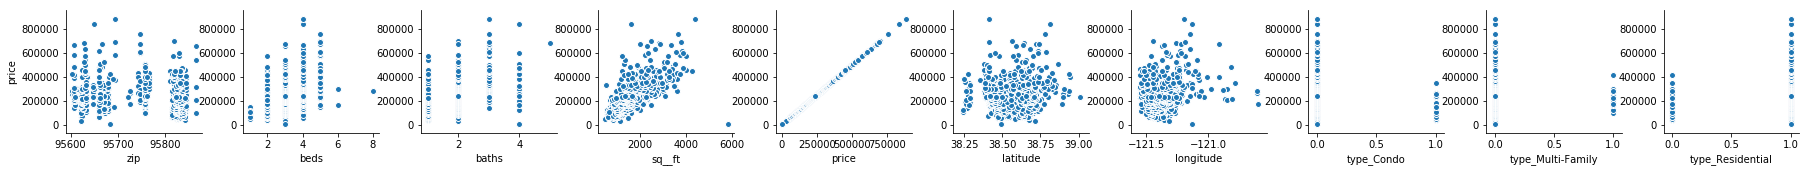

In [21]:
sns.pairplot(sac, 
             x_vars=sac.select_dtypes(exclude='object').columns.tolist(), 
             y_vars=['price'])

#### Let's go with sq__ft, longitude, type_Condo

In [22]:
sac.corr()['price'].abs().sort_values(ascending=False)[1:]

sq__ft               0.693237
baths                0.499183
beds                 0.442519
longitude            0.280181
zip                  0.219874
type_Condo           0.186680
type_Residential     0.166559
latitude             0.062023
type_Multi-Family    0.004973
Name: price, dtype: float64

In [23]:
lm = LinearRegression()

In [24]:
# create factor and target matricies
# factor X
X = sac[['sq__ft', 'longitude', 'type_Condo']]
# target y
y = sac['price']

In [25]:
print(type(X), type(y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [26]:
print(X.shape, y.shape)

(812, 3) (812,)


In [27]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
lm.coef_

array([  1.19756539e+02,   1.88249922e+05,  -2.39701287e+04])

In [29]:
y_hat = pd.DataFrame(data=lm.predict(X).tolist(), columns=['p_pred'])

In [30]:
res = X.join(pd.DataFrame(y)).join(y_hat)

In [31]:
res.isnull().sum()

sq__ft        0
longitude     0
type_Condo    0
price         0
p_pred        0
dtype: int64

In [32]:
# sqrt error resid (does not coincide w/ solns)
# res['diff'] = np.sqrt((res['p_pred'] - res['price'])**2)
res['diff'] = res['price'] - res['p_pred']

In [33]:
res.head(2)

,sq__ft,longitude,type_Condo,price,p_pred,diff
0,836,-121.434879,0,59222,129664.333690,-70442.333690
1,1167,-121.431028,0,68212,170028.698606,-101816.698606


### 5. Plot the residuals against the true points to evaluate your MLR visually.

> **Tip:** with seaborn's `sns.lmplot` you can set `x`, `y`, and even a `hue` (which will plot regression lines by category in different colors) to easily plot a regression line.

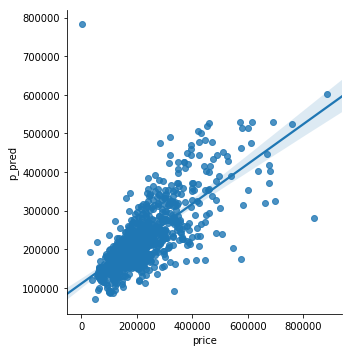

In [36]:
# if our model is good (which it totally isn't), all those dots will line on the superimposed line

sns.lmplot('price', 'p_pred', res)

### 6. List the five assumptions for an MLR model. 

Indicate which ones are the same as the assumptions for an SLR model. 

1. **Linearity:** $Y$ must have an approximately linear relationship with each independent $X_i$.
2. **Independence:** Errors (residuals) $\epsilon_i$ and $\epsilon_j$ must be independent of one another for any $i \ne j$.
3. **Normality:** The errors (residuals) follow a Normal distribution.
4. **Equality of Variances**: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the $X_i$ predictors. (There should be no discernable relationship between the $X$ predictors and the residuals.)
5. **Independence of Predictors**: The independent variables $X_i$ and $X_j$ must be independent of one another for any $i \ne j$.


### 7. Pick at least two assumptions and articulate whether or not you believe them to be met  for your model and why.

In [95]:
def check_normality(df):
    normal_dict = {'isnormal': []}
    index_items = []
    for column in df.columns.tolist():
        index_items.append(column)
        normal_dict['isnormal'].append(1 if stats.normaltest(df[column])[1] > 0.05 else 0)
    return(pd.DataFrame(normal_dict, index=index_items))

In [96]:
# no columns are normal
check_normality(res)

,isnormal
sq__ft,0
longitude,0
type_Condo,0
price,0
p_pred,0
diff,0


### 8. Explain what the intercept in your model means in the context of your predictor variables.

#### When sq__ft, longitude, and type_Condo are all 0, the price of the house is estimated to be the value of the intercept.

### 9. Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` function.

In [98]:
# Importing the stats model API
import statsmodels.api as sm

# Setting my X and y for modeling
X = res[['sq__ft','longitude','type_Condo']]
y = res['price']

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
model.summary()

/home/greg/miniconda3/envs/ga/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     2161.
Date:                Tue, 30 Jan 2018   Prob (F-statistic):               0.00
Time:                        09:47:41   Log-Likelihood:                -10379.
No. Observations:                 812   AIC:                         2.076e+04
Df Residuals:                     809   BIC:                         2.078e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sq__ft       124.7739      4.716     26.458      0.000     115.517     134.031
longitude   -264.1578     67.983     -3.886      0.000    -397.601    -130.714
type_Condo -2.169e+04   1.42e+04     -1.532      0.126   -4.95e+04    6093.267
==============================================================================
Omnibus:                      221.587   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4907.925
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                      14.969   Cond. No.                     8.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 10. [Bonus] Summarize your findings.

You work for a real estate agency. You are asked to prepare an executive summary for your very busy boss highlighting the most important findings from your MLR model. Convey these findings in no more than two paragraphs. Be sure to briefly address any potential shortcomings of your model.


In [ ]:
# A: 